# Detecção de bordas
## Aula 10

* Bordas são mudanças drásticas de iluminação na imagem;
* Normalmente ocorrem em regiões distintas da imagem;
* Usada como pré-processamento para extração de características (ajudam a detectar fronteiras de objetos), descanta informações desnecessárias à imagem, como ruído, o próprio contraste de tons, etc.

Uma borda ideal seria uma função representada por um degrau:

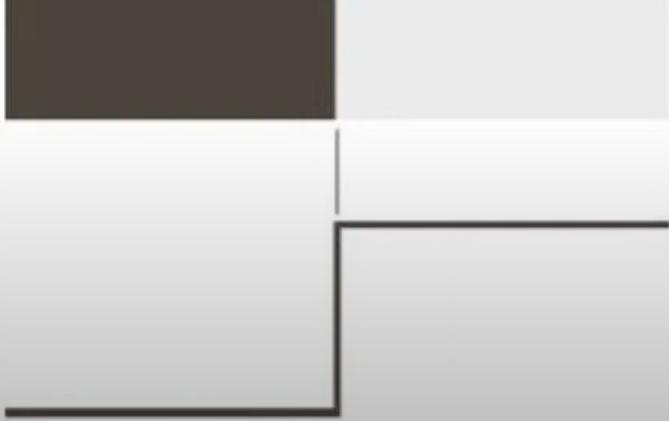   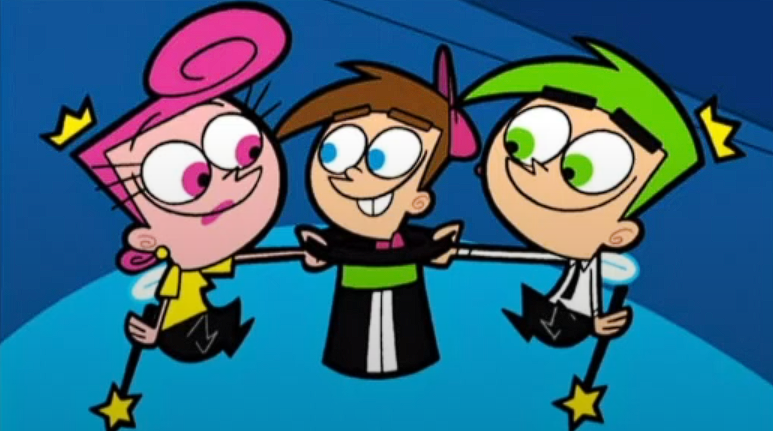



Bordas reais (rampa), porém, podem ser visualizadas pela variação:

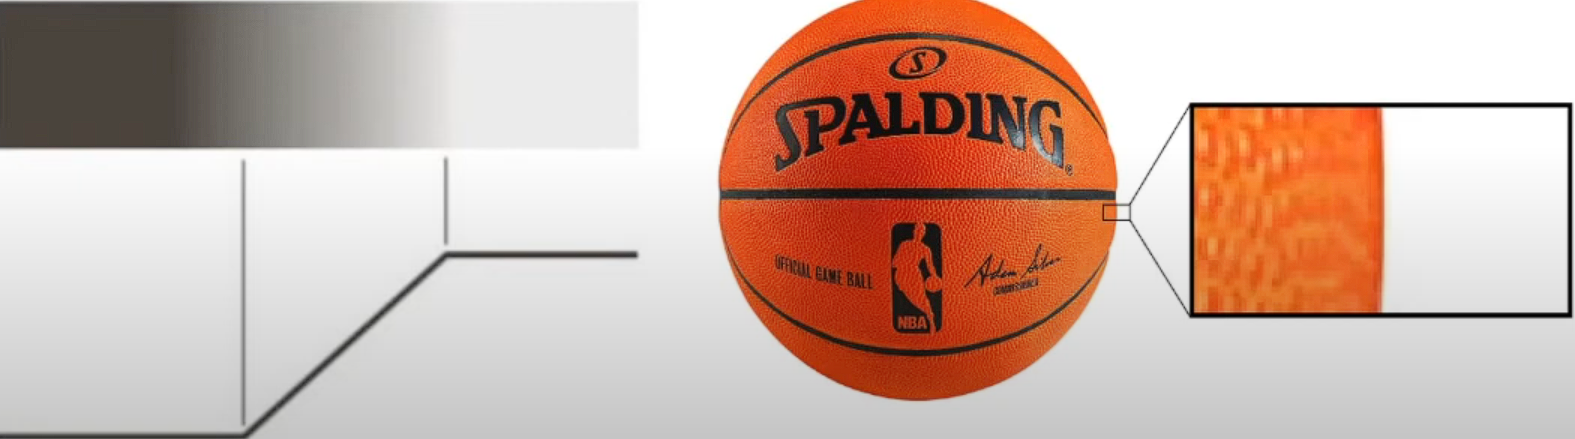

Fazendo o gráfico da derivada da linha 950 da imagem em escala de cinza:

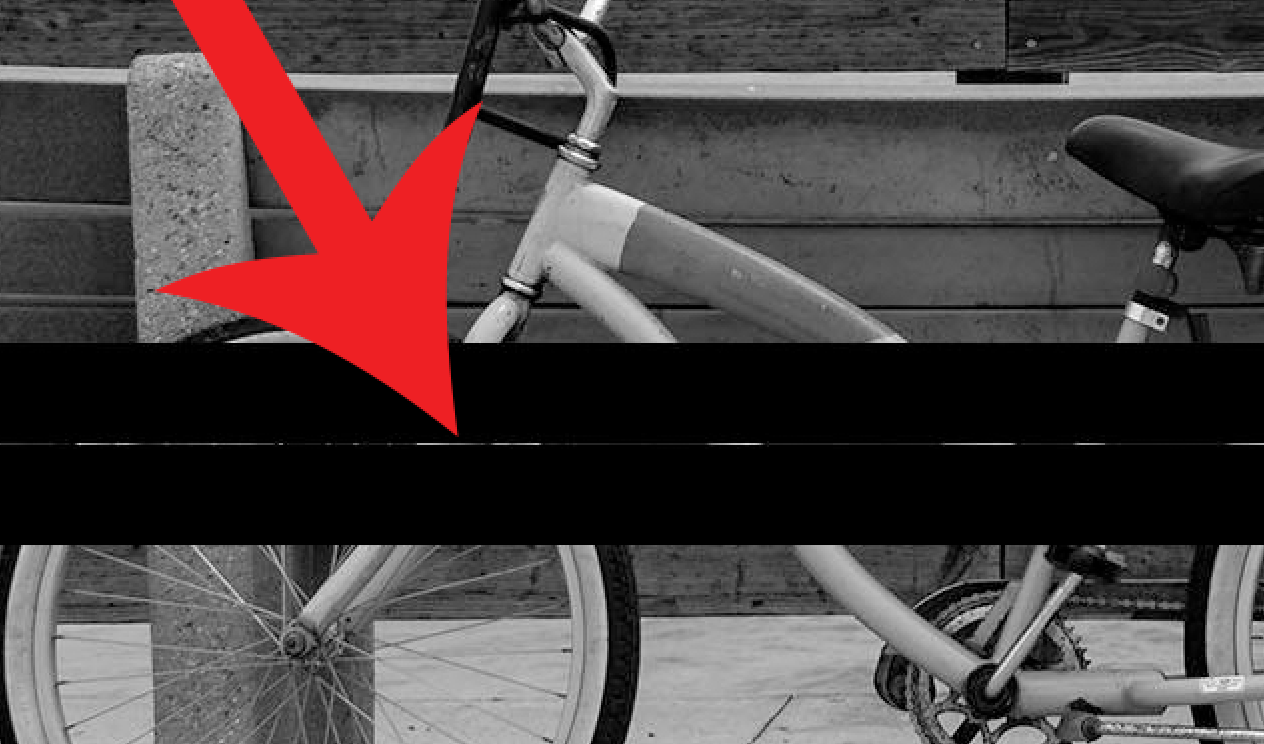

Obtemos:

|Intesidade de pixels na linha 950|
|-|
|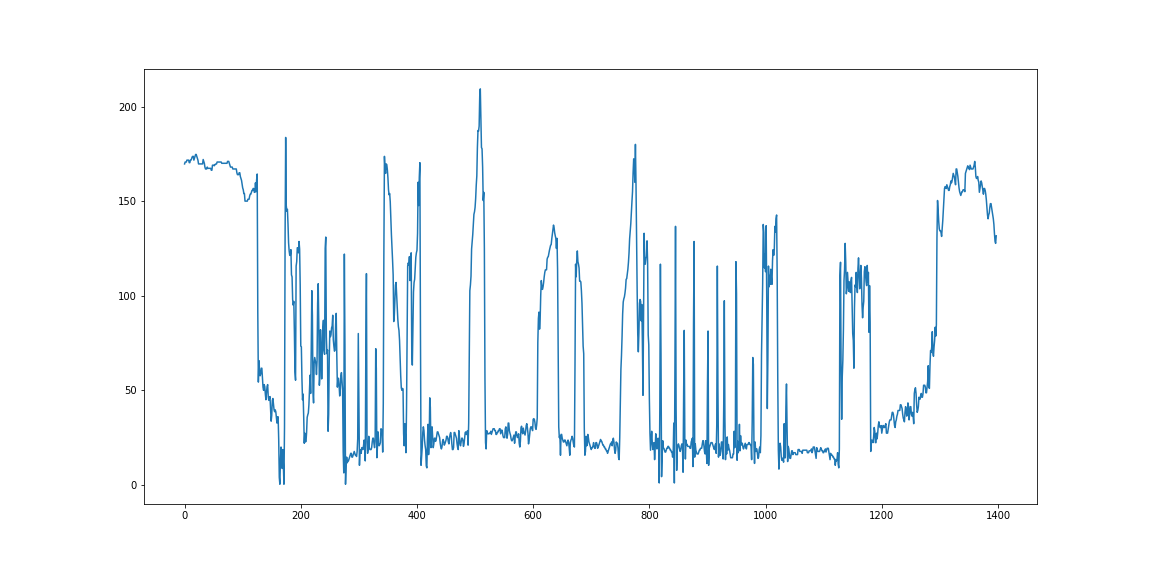|

|Primeira derivada (bordas localizadas nos picos)|
|-|
|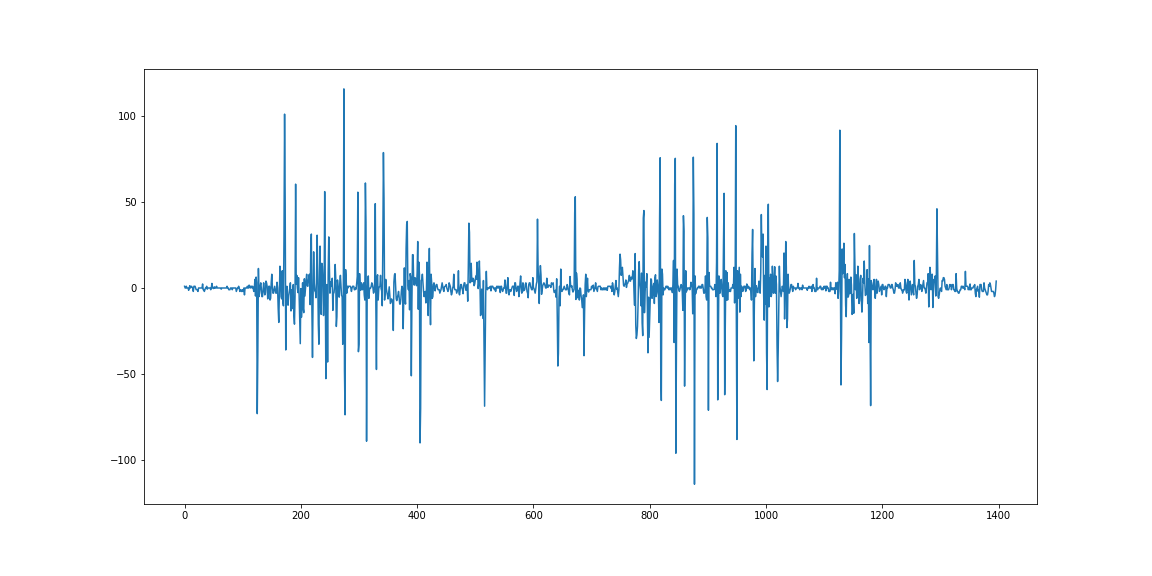|

|Segunda derivada (bordas localizadas nos zeros)|
|-|
|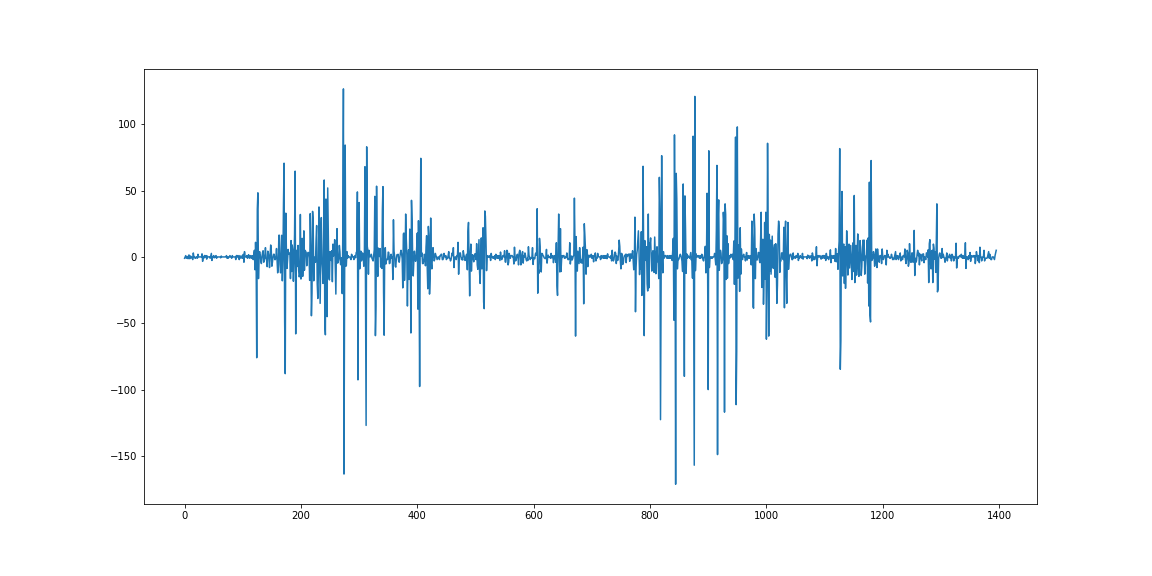|


Exemplo prático:

https://youtube.com/shorts/DNIQdUHHB7A?si=Lhdxy1o-I9CaZe8L

## Detecção de bordas com NumPy

Primeiramente, importamos nossas bibliotecas usuais:

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.ndimage import convolve


Trabalharemos com a imagem `museum.jpg`, mas primeiro devemos convertê-la para escala de cinza. Usamos o método _average_ para este exemplo.

In [30]:
museum_rgb = np.array(Image.open("museum.jpg"))[:, :, :3]
l, c, p = museum_rgb.shape

# converter para escala de cinza:
museum = np.zeros(shape=(l, c), dtype=np.uint8)
for i in range(l):
    for j in range(c):
        r = float(museum_rgb[i, j, 0])
        g = float(museum_rgb[i, j, 1])
        b = float(museum_rgb[i, j, 2])
        
        museum[i, j] = (r + g + b) / 3

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.imshow(museum_rgb)
plt.subplot(1, 2, 2)
plt.imshow(museum, cmap='gray')

FileNotFoundError: [Errno 2] No such file or directory: 'museum.jpg'

Tendo a imagem em escala de cinza, podemos calcular as derivadas horizontal e vertical da imagem e combiná-las para achar as bordas, e por fim aplicar um threshold:

In [8]:
# Calcula a diferença absoluta entre linhas adjacentes (derivada das colunas)
# `np.diff(museum.astype(np.float64), axis=0)` calcula a diferença entre cada linha e a anterior
# `append=255` adiciona uma linha extra preenchida com 255 para manter a dimensão original
# `np.abs()` converte os valores negativos para positivos
abs_tg_c = np.abs(np.diff(museum.astype(np.float64), axis=0, append=255))

# Calcula a diferença absoluta entre colunas adjacentes (derivada das linhas)
# `np.diff(museum.astype(np.float64), axis=1)` calcula a diferença entre cada coluna e a anterior
# `append=255` adiciona uma coluna extra preenchida com 255 para manter a dimensão original
# `np.abs()` converte os valores negativos para positivos
abs_tg_l = np.abs(np.diff(museum.astype(np.float64), axis=1, append=255))

# Combina as derivadas das linhas e colunas utilizando a norma L2 (distância euclidiana)
# Isso resulta em uma medida de variação da intensidade dos pixels
abs_tg = np.sqrt(abs_tg_c ** 2 + abs_tg_l ** 2)

# Define um valor de limiar (threshold) para detectar bordas
threshold = 16

# Cria uma matriz de zeros com o mesmo tamanho da imagem original
# Essa matriz armazenará a imagem de bordas detectadas
museum_border = np.zeros(shape=(l, c), dtype=np.uint8)

# Define como branco (255) os pixels onde a variação de intensidade (abs_tg) é maior que o threshold
museum_border[abs_tg > threshold] = 255

# A linha abaixo é redundante, pois a matriz já foi inicializada com zeros
# museum_border[abs_tg <= threshold] = 0

# Versão iterativa do thresholding acima (equivalente ao método vetorizado usado anteriormente):
# Para cada pixel na imagem:
#   - Se a intensidade da borda for maior que o threshold, define como branco (255)
#   - Caso contrário, mantém como preto (0), o que já é o valor padrão da matriz
# for i in range(l):
#     for j in range(c):
#         if abs_tg[i, j] > threshold:
#             museum_border[i, j] = 255
#         else:
#             museum_border[i, j] = 0  # redundante, pois já inicializamos com zeros


NameError: name 'museum' is not defined

E com o código acima obtemos os seguintes resultados:

In [9]:
plt.figure(figsize=(16, 16))

plt.subplot(2, 2, 1)
plt.title("Imagem original em cinza")
plt.imshow(museum, cmap='gray')

plt.subplot(2, 2, 2)
plt.title("Derivadas das linhas")
plt.imshow(abs_tg_l, cmap='gray')

plt.subplot(2, 2, 3)
plt.title("Derivadas das colunas")
plt.imshow(abs_tg_c, cmap='gray')

plt.subplot(2, 2, 4)
plt.title("Derivadas")
plt.imshow(abs_tg, cmap='gray')

NameError: name 'plt' is not defined

In [10]:
plt.figure(figsize=(8, 8))
plt.title("Tangentes após threshold")
plt.imshow(museum_border, cmap='gray')
print(museum_border.shape)

NameError: name 'plt' is not defined

In [11]:
poster = np.array(Image.open('poster.jpg'))[:,:,:3]
print(poster.shape)

#masked = museum_border & poster # Operação da errado devido ao número de páginas diferentes

masked = np.zeros(shape = poster.shape, dtype = np.uint8)
masked[:,:,0] = museum_border & poster[:,:,0]
masked[:,:,1] = museum_border & poster[:,:,1]
masked[:,:,2] = museum_border & poster[:,:,2]


plt.figure(figsize=(16,16))
plt.imshow(poster)

NameError: name 'Image' is not defined

## Normais

* Um vetor normal é aquele que aponta para fora da superfície;
* Perpendicular ao plano tangente à superfície;
* Como as derivadas calculam as tangentes da imagem, podemos estimar as normais da mesma.

Pode ser calculado de acordo com a seguinte equação:

$$
\begin{bmatrix}
r \\
g \\
b
\end{bmatrix} = \begin{bmatrix}
\frac{-\partial_x(I) + 255}{2} \\
\frac{ \partial_y(I) + 255}{2} \\
255 - \nabla I
\end{bmatrix}
$$

Na qual:
* $I$: Imagem de entrada;
* $\partial_x(I)$: Derivada de $I$ sobre as colunas (`np.diff(I, axis=1, append=255)`);
* $\partial_y(I)$: Derivada de $I$ sobre as linhas (`np.diff(I, axis=0, append=255)`);
* $\nabla I = \sqrt{(\partial_x(I))^2+(\partial_y(I))^2}$: Gradiente de $I$.

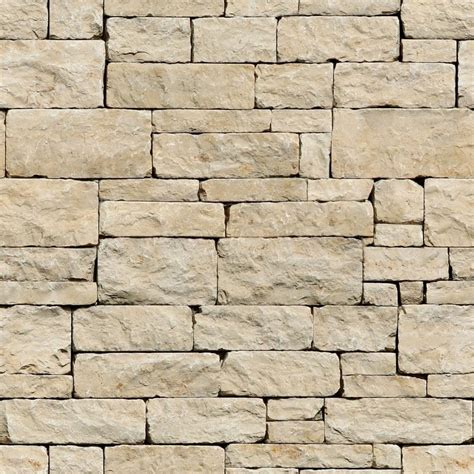

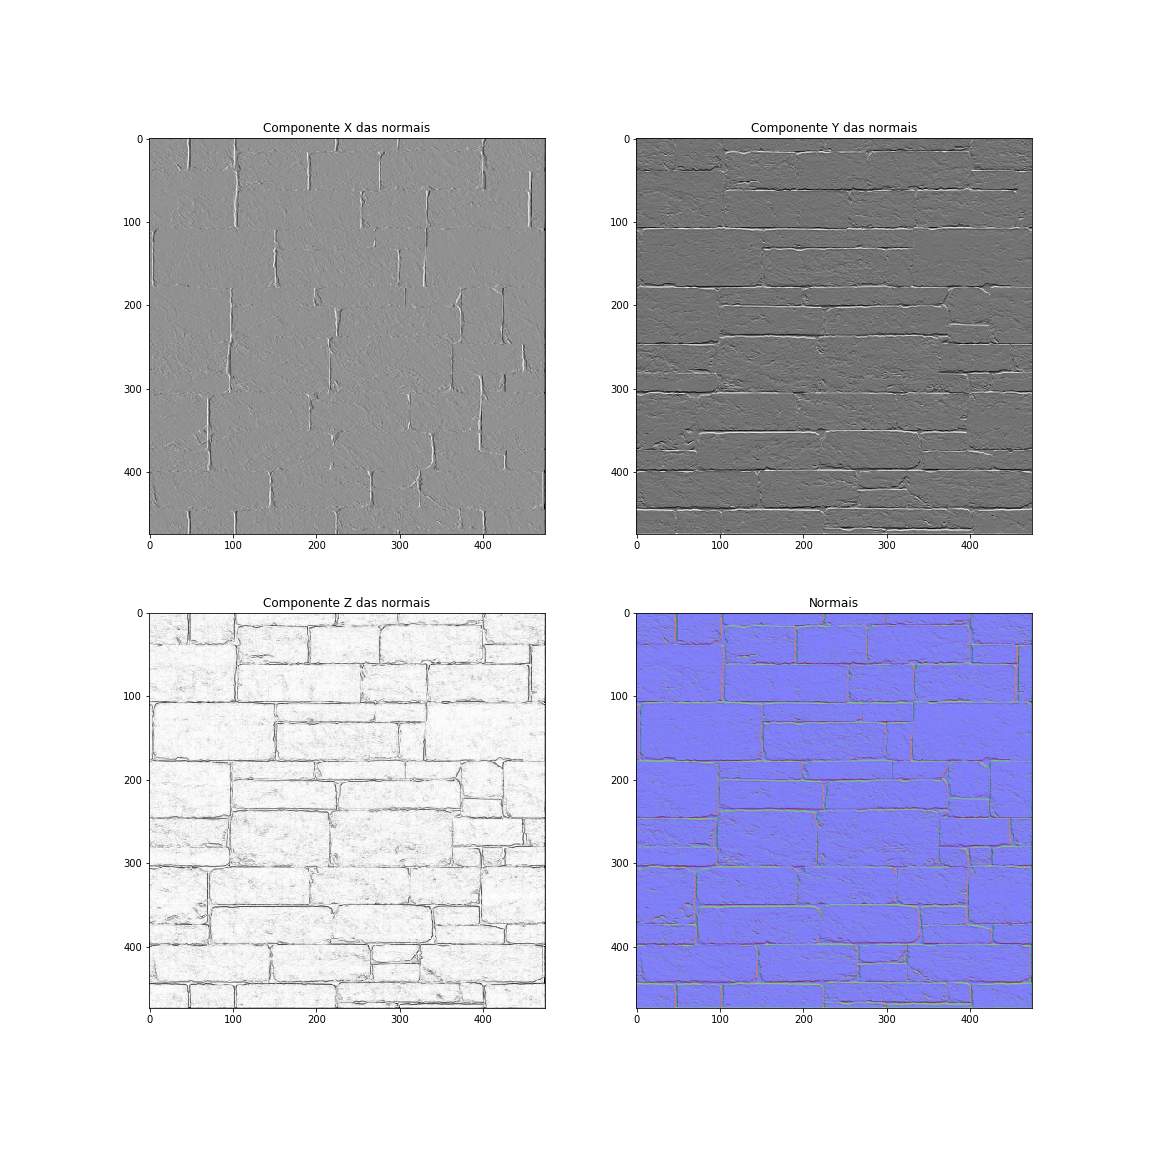

Na imagem abaixo, gerada com a figura `bricks.jpg` e renderizada no Unity com a normal acima, percebe-se o efeito do cubo com a luz, que só foi possível devido às normais.

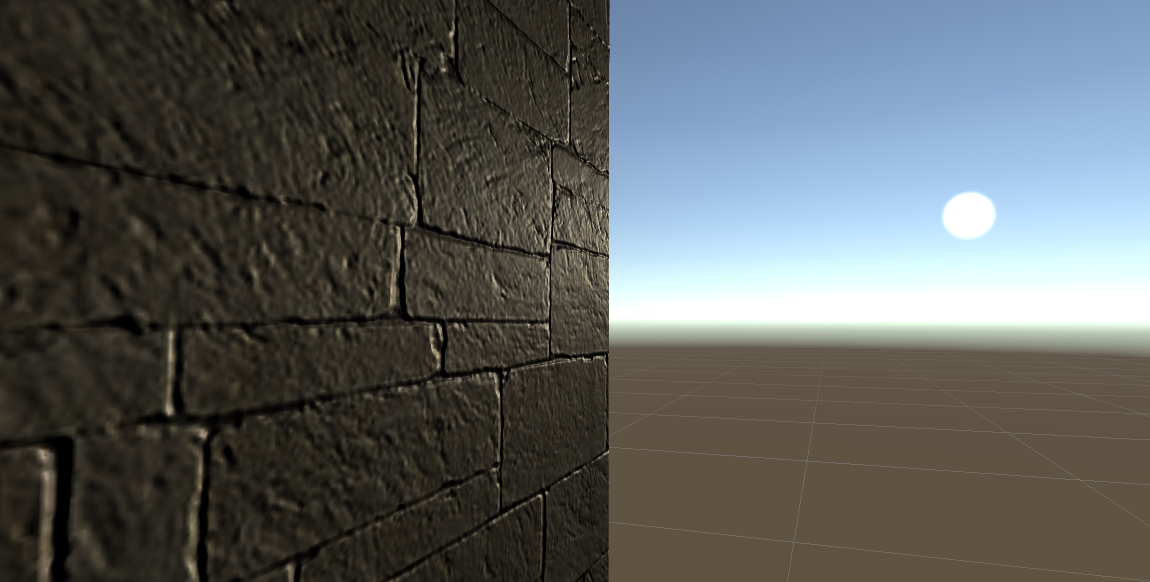

## Detecção de bordas com convolução

Podemos também detectar bordas utilizando métodos de convolução. Alguns métodos incluem:
* Sobel;
* Scharr;
* Prewitt;
* Roberts;
* Canny;
* Etc.

### Convolução

* Para o processamento de imagens, frequentemente utilizamos de um **kernel** (matriz de convolução);
* Aplica um **filtro** a uma imagem;
* Denotado pelo operador $*$.

A ideia da convolução é fazer uma média ponderada com todos os vizinhos de um determinado pixel, utilizando o kernel como pesos, de acordo com a fórmula abaixo:
$$
g(x,y) = \omega * f(x,y) = \sum_{s=-a}^{a}\sum_{t=-b}^{b} \omega(s,t)f(x-s,y-t)
$$

Na qual:
* $g(x,y)$: imagem filtrada;
* $f(x,y)$: imagem original;
* $\omega$: kernel de filtro;
* $a$ e $b$: índices máximos do kernel.

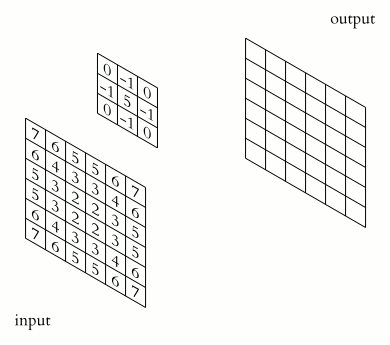

In [ ]:
# Argumentos:
# * image: imagem grayscale de entrada (corresponde ao f da fórmula)
# * kernel: filtro de convolução
# Retorno:
# * a convolução entre image e kernel
def conv(image, kernel):
    m, n = kernel.shape
    # assert verifica se uma condição é verdadeira
    # e mostra uma mensagem de erro caso falhe:
    assert m == n, "Kernel deve ser uma matriz quadrada."
    l, c = image.shape
    
    # novas dimensões da imagem (imagem menos o tamanho do filtro):
    new_l = l - m + 1
    new_c = c - n + 1
    new_image = np.zeros(shape=(new_l, new_c))
    for i in range(new_l):
        for j in range(new_c):
            # soma da multiplicação ponto-a-ponto entre o kernel e a
            # imagem (recorte do trecho da imagem do mesmo tamanho do kernel):
            new_image[i, j] = np.sum(image[i:i + n, j:j + m] * kernel)
    
    return new_image

A detecção de bordas com convolução normalmente é feita com dois _kernels_ e pode ser feita da seguinte forma:
* Para melhores resultados, normalize a imagem para a faixa de `[0, 1]` (isto é, divida-a por 255);
* Compute a convolução da imagem com o _kernel_ em x;
* Compute a convolução da imagem com o _kernel_ em y;
* Calcule o gradiente das convoluções (`np.sqrt(conv_x ** 2 + conv_y ** 2`).

Segue uma tabela com alguns kernels:

|Método|Kernel em X|Kernel em Y|Entrada|Saída|
|-|-|-|-|-|
|**Sobel**|$$\begin{bmatrix}1&0&-1\\2&0&-2\\1&0&-1\end{bmatrix}$$|$$\begin{bmatrix}1&2&1\\0&0&0\\-1&-2&-1\end{bmatrix}$$|<img src="Bikesgray.jpg" style="height:200px"/>|<img src="attachment:sobel.png" style="height:200px"/>|
|**Prewitt**|$$\begin{bmatrix}1&0&-1\\1&0&-1\\1&0&-1\end{bmatrix}$$|$$\begin{bmatrix}1&1&1\\0&0&0\\-1&-1&-1\end{bmatrix}$$|<img src="Bikesgray.jpg" style="height:200px"/>|<img src="attachment:prewitt.png" style="height:200px"/>|
|**Roberts cross**|$$\begin{bmatrix}1&0\\0&-1\end{bmatrix}$$|$$\begin{bmatrix}0&1\\-1&0\end{bmatrix}$$|<img src="Bikesgray.jpg" style="height:200px"/>|<img src="attachment:roberts.png" style="height:200px"/>|

In [ ]:
def roberts_cross(img):
    kernel_x = np.array([[1, 0], [ 0, -1]], dtype=np.float64)
    kernel_y = np.array([[0, 1], [-1,  0]], dtype=np.float64)
    
    conv_x = conv(img, kernel_x)
    conv_y = conv(img, kernel_y)
    
    # np.hypot(x, y) é o mesmo que np.sqrt((x ** 2) + (y ** 2))
    gradient = np.hypot(conv_x, conv_y)
    
    return gradient

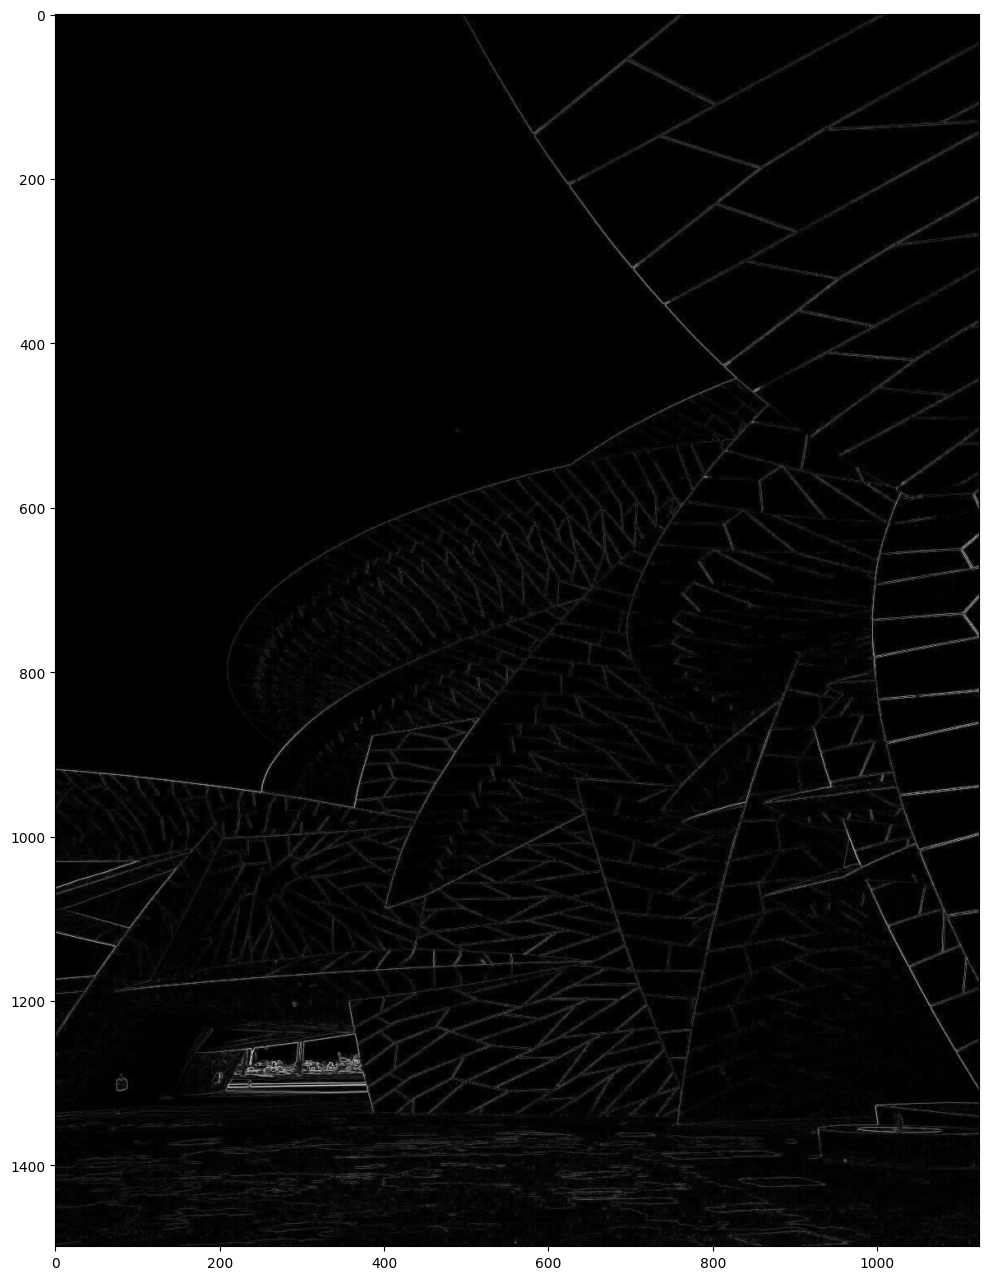

In [ ]:
plt.figure(figsize=(16, 16))
plt.imshow(roberts_cross(museum / 255), cmap='gray')


## Exercícios

1. Implemente o método de detecção de normais apresentado acima.

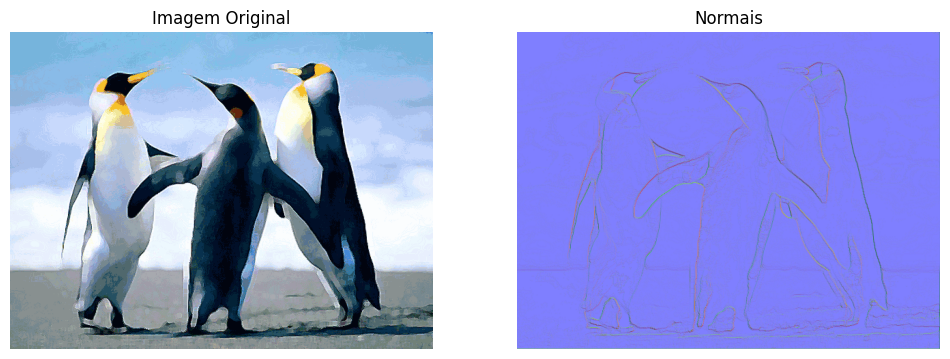

In [31]:
def calcular_normais(imagem):
    if len(imagem.shape) == 3:
        imagem = np.mean(imagem, axis=2).astype(np.uint8)
    
    partial_x = np.diff(imagem, axis=1, append=255)
    partial_y = np.diff(imagem, axis=0, append=255)
    
    gradiente = np.sqrt(partial_x**2 + partial_y**2)
    
    r = (-partial_x + 255) / 2
    g = (partial_y + 255) / 2
    b = 255 - gradiente
    
    normais = np.stack((r, g, b), axis=-1).astype(np.uint8)
    
    return normais

imagem = np.array(Image.open('img.jpg'))

normais = calcular_normais(imagem)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Imagem Original")
plt.imshow(imagem, cmap='gray' if len(imagem.shape) == 2 else None)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Normais")
plt.imshow(normais)
plt.axis('off')

plt.show()

2. Escolha algum dos métodos de detecção de borda com convolução acima (exceto Roberts cross) e utilize-o em uma imagem de sua escolha. 

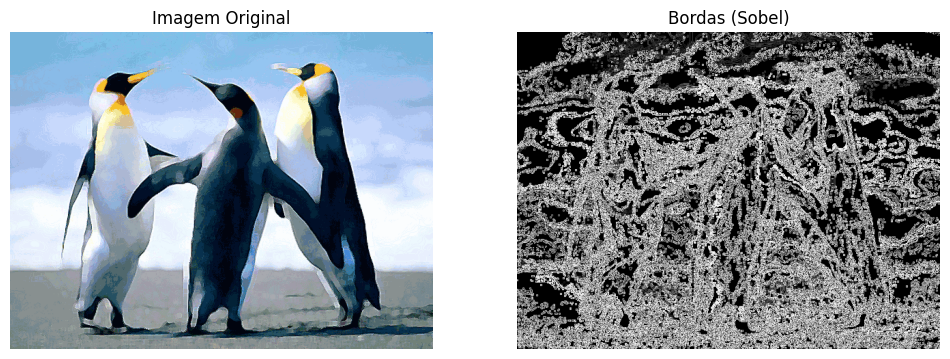

In [27]:

def detectar_bordas_sobel(imagem):
    if len(imagem.shape) == 3:
        imagem = np.mean(imagem, axis=2).astype(np.uint8)
    
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
    
    sobel_y = np.array([[-1, -2, -1],
                        [ 0,  0,  0],
                        [ 1,  2,  1]])
    
    bordas_x = convolve(imagem, sobel_x)
    bordas_y = convolve(imagem, sobel_y)
    
    bordas = np.sqrt(bordas_x**2 + bordas_y**2)
    bordas = (bordas / bordas.max() * 255).astype(np.uint8)
    
    return bordas

imagem = np.array(Image.open('img.jpg'))

bordas = detectar_bordas_sobel(imagem)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Imagem Original")
plt.imshow(imagem, cmap='gray' if len(imagem.shape) == 2 else None)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Bordas (Sobel)")
plt.imshow(bordas, cmap='gray')
plt.axis('off')

plt.show()

# Referências
* https://en.wikipedia.org/wiki/Finite_difference
* https://www.cse.usf.edu/~r1k/MachineVisionBook/MachineVision.files/MachineVision_Chapter5.pdf
* https://en.wikipedia.org/wiki/Edge_detection
* https://en.wikipedia.org/wiki/Normal_mapping
* https://en.wikipedia.org/wiki/Prewitt_operator
* https://en.wikipedia.org/wiki/Sobel_operator
* https://homepages.inf.ed.ac.uk/rbf/HIPR2/sobel.htm
* http://www.songho.ca/dsp/convolution/convolution.html#convolution_2d
* http://www.songho.ca/dsp/convolution/convolution2d_example.html
* https://en.wikipedia.org/wiki/Kernel_(image_processing)
* https://pdfs.semanticscholar.org/cc43/a71e05cfc49ab0777b82ca94d181f779149f.pdf

Aula remota, conforme Port. 345/2020 – MEC